## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [86]:
import torch
from torch import optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [11]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [12]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [13]:
len(fmnist_dataset_test)

10000

In [14]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [98]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [99]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


Your experiments come here:

In [100]:
model = TinyNeuralNetwork().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
loaders = {"train": train_loader, "valid": test_loader}

In [102]:
#check
batch = next(iter(train_loader))
model.forward(torch.FloatTensor(batch[0]))

tensor([[-0.1196, -0.1015,  0.0143,  ..., -0.1481, -0.2698,  0.0136],
        [-0.0166, -0.0654,  0.0831,  ...,  0.0649, -0.2510, -0.0447],
        [ 0.0199, -0.0178, -0.0376,  ...,  0.0339, -0.1235, -0.0215],
        ...,
        [-0.0595,  0.0500, -0.0192,  ...,  0.0854, -0.2288, -0.0067],
        [-0.0321, -0.0549,  0.0885,  ...,  0.0924, -0.2558, -0.1212],
        [-0.0365,  0.0315,  0.0479,  ...,  0.0904, -0.3143, -0.0689]],
       grad_fn=<AddmmBackward0>)

In [83]:
model.to(device)

TinyNeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [103]:
max_epochs = 10
batch_size = 128

In [104]:
accuracy_TinyNeuralNetwork = {"train": [], "valid": []}

In [105]:
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train() 
                optimizer.zero_grad()
                output = model(x_batch) 
            else:
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)
            preds = output.argmax(-1) 
            correct = (preds == y_batch).float().sum() 
            all = y_batch.size(0)  
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy_TinyNeuralNetwork[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.79805
Loader: valid. Accuracy: 0.8263
Epoch: 2
Loader: train. Accuracy: 0.8514666666666667
Loader: valid. Accuracy: 0.8493
Epoch: 3
Loader: train. Accuracy: 0.8677833333333334
Loader: valid. Accuracy: 0.8494
Epoch: 4
Loader: train. Accuracy: 0.8755
Loader: valid. Accuracy: 0.8651
Epoch: 5
Loader: train. Accuracy: 0.8800666666666667
Loader: valid. Accuracy: 0.8663
Epoch: 6
Loader: train. Accuracy: 0.8862666666666666
Loader: valid. Accuracy: 0.8574
Epoch: 7
Loader: train. Accuracy: 0.8885166666666666
Loader: valid. Accuracy: 0.8735
Epoch: 8
Loader: train. Accuracy: 0.8932333333333333
Loader: valid. Accuracy: 0.8754
Epoch: 9
Loader: train. Accuracy: 0.8960333333333333
Loader: valid. Accuracy: 0.8673
Epoch: 10
Loader: train. Accuracy: 0.89985
Loader: valid. Accuracy: 0.8717


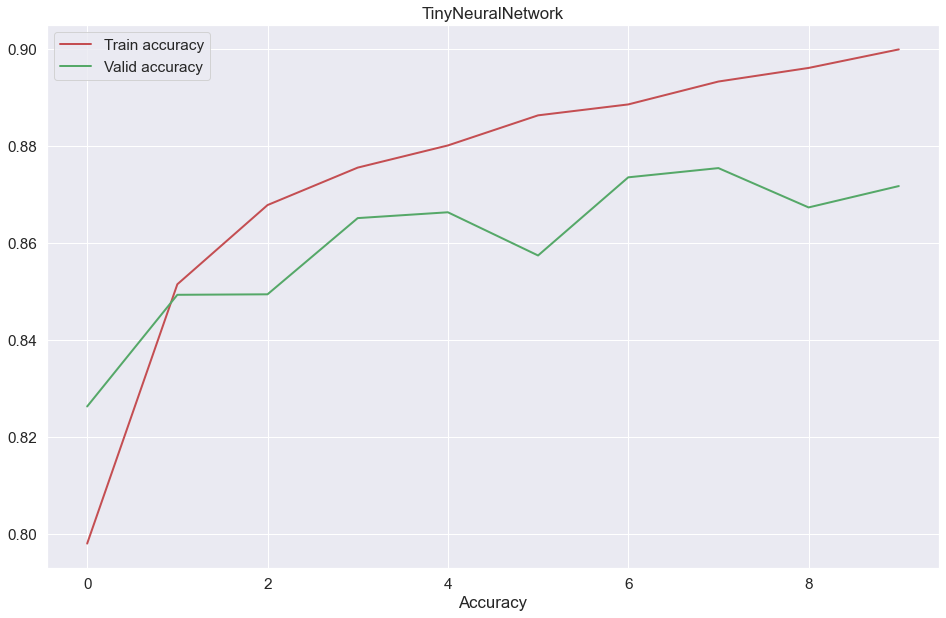

In [129]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("TinyNeuralNetwork")
plt.plot(range(max_epochs), accuracy_TinyNeuralNetwork["train"], color = 'r', label="Train accuracy", linewidth=2)
plt.plot(range(max_epochs), accuracy_TinyNeuralNetwork["valid"], color = 'g', label="Valid accuracy", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.xlabel("Accuracy")
plt.show()

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [135]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,128),
             nn.Linear(128,128),
            nn.ReLU(),
             nn.Linear(128,128),
            nn.ReLU(),
            activation(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [136]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
             ReLU-10                  [-1, 128]               0
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 167,818
Trainable params: 167,818
Non-trainable params: 0
-------------------------------

In [137]:
model = OverfittingNeuralNetwork().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
loaders = {"train": train_loader, "valid": test_loader}

In [138]:
accuracy_OverfittingNeuralNetwork = {"train": [], "valid": []}

In [139]:
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train() 
                optimizer.zero_grad()
                output = model(x_batch) 
            else:
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)
            preds = output.argmax(-1) 
            correct = (preds == y_batch).float().sum() 
            all = y_batch.size(0)  
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy_OverfittingNeuralNetwork[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7476166666666667
Loader: valid. Accuracy: 0.8239
Epoch: 2
Loader: train. Accuracy: 0.84595
Loader: valid. Accuracy: 0.8432
Epoch: 3
Loader: train. Accuracy: 0.8647166666666667
Loader: valid. Accuracy: 0.85
Epoch: 4
Loader: train. Accuracy: 0.8760333333333333
Loader: valid. Accuracy: 0.8589
Epoch: 5
Loader: train. Accuracy: 0.8823666666666666
Loader: valid. Accuracy: 0.8709
Epoch: 6
Loader: train. Accuracy: 0.88625
Loader: valid. Accuracy: 0.8684
Epoch: 7
Loader: train. Accuracy: 0.89055
Loader: valid. Accuracy: 0.8704
Epoch: 8
Loader: train. Accuracy: 0.8947
Loader: valid. Accuracy: 0.8791
Epoch: 9
Loader: train. Accuracy: 0.8976
Loader: valid. Accuracy: 0.8746
Epoch: 10
Loader: train. Accuracy: 0.9026333333333333
Loader: valid. Accuracy: 0.8753


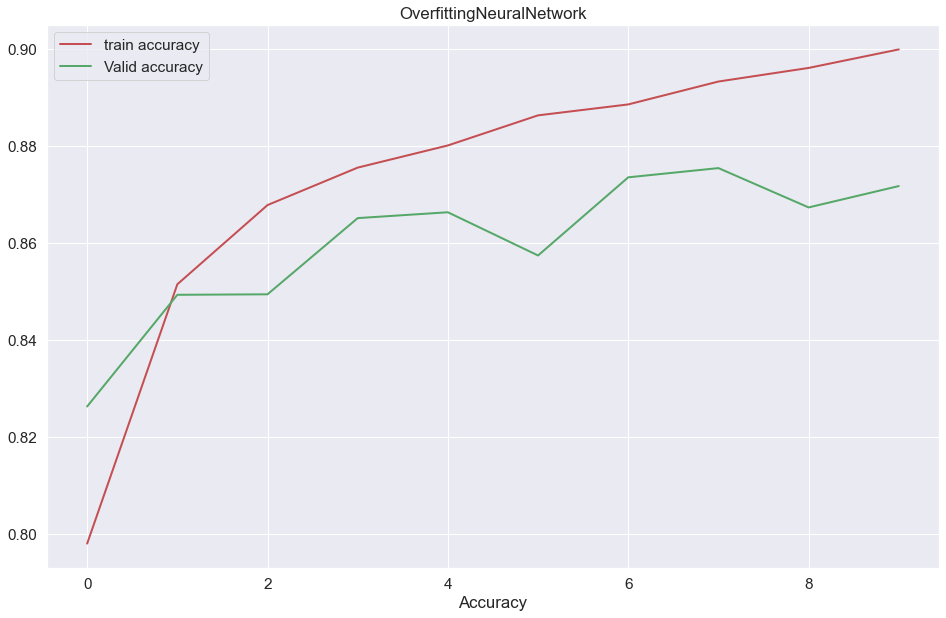

In [140]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("OverfittingNeuralNetwork")
plt.plot(range(max_epochs), accuracy_TinyNeuralNetwork["train"], color = 'r', label="train accuracy", linewidth=2)
plt.plot(range(max_epochs), accuracy_TinyNeuralNetwork["valid"],color = 'g', label="Valid accuracy", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.xlabel("Accuracy")
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [152]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [153]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                  [

In [158]:
model = FixedNeuralNetwork().to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.99))
criterion = nn.CrossEntropyLoss()
loaders = {"train": train_loader, "valid": test_loader}

In [159]:
accuracy_FixedNeuralNetwork = {"train": [], "valid": []}

In [160]:
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train() 
                optimizer.zero_grad()
                output = model(x_batch) 
            else:
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)
            preds = output.argmax(-1) 
            correct = (preds == y_batch).float().sum() 
            all = y_batch.size(0)  
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy_FixedNeuralNetwork[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.7080833333333333
Loader: valid. Accuracy: 0.8112
Epoch: 2
Loader: train. Accuracy: 0.7955333333333333
Loader: valid. Accuracy: 0.8381
Epoch: 3
Loader: train. Accuracy: 0.8173666666666667
Loader: valid. Accuracy: 0.8505
Epoch: 4
Loader: train. Accuracy: 0.8267333333333333
Loader: valid. Accuracy: 0.8535
Epoch: 5
Loader: train. Accuracy: 0.8331166666666666
Loader: valid. Accuracy: 0.8604
Epoch: 6
Loader: train. Accuracy: 0.8382166666666667
Loader: valid. Accuracy: 0.8584
Epoch: 7
Loader: train. Accuracy: 0.8439166666666666
Loader: valid. Accuracy: 0.8649
Epoch: 8
Loader: train. Accuracy: 0.8457666666666667
Loader: valid. Accuracy: 0.8666
Epoch: 9
Loader: train. Accuracy: 0.8484833333333334
Loader: valid. Accuracy: 0.864
Epoch: 10
Loader: train. Accuracy: 0.8499333333333333
Loader: valid. Accuracy: 0.8641


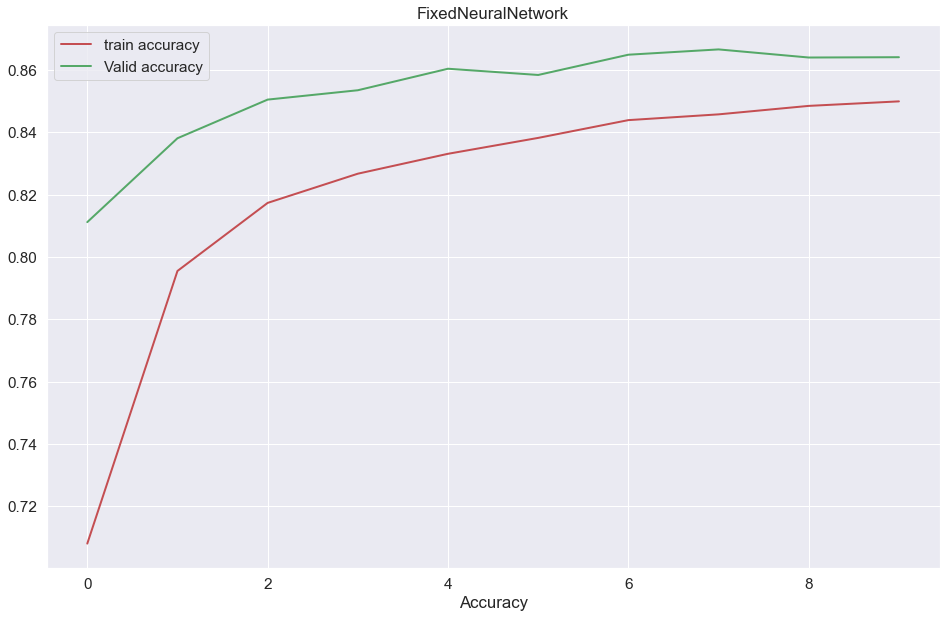

In [161]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("FixedNeuralNetwork")
plt.plot(range(max_epochs), accuracy_FixedNeuralNetwork["train"], color = 'r', label="train accuracy", linewidth=2)
plt.plot(range(max_epochs), accuracy_FixedNeuralNetwork["valid"],color = 'g', label="Valid accuracy", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.xlabel("Accuracy")
plt.show()

### Conclusions:
As in theory, dropout and batchnorm help with retraining, which means they are regularization methods

## Let's improve the metric a little, using a convolutional network

In [168]:

import torch.nn.functional as F 

In [304]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2) 
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x):
        # Convolution-> ReLu-> Pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size()[0], -1)

        # Полностью связанный слой
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [305]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.99))

loader_LeNet = {"train": train_loader, "valid": test_loader}

In [306]:
accuracy_LeNet = {"train": [], "valid": []}

In [307]:
max_epochs = 10

In [308]:
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train() 
                optimizer.zero_grad()
                output = model(x_batch) 
            else:
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)
            preds = output.argmax(-1) 
            correct = (preds == y_batch).float().sum() 
            all = y_batch.size(0)  
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy_LeNet[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.77145
Loader: valid. Accuracy: 0.8328
Epoch: 2
Loader: train. Accuracy: 0.8573166666666666
Loader: valid. Accuracy: 0.8659
Epoch: 3
Loader: train. Accuracy: 0.8752333333333333
Loader: valid. Accuracy: 0.8748
Epoch: 4
Loader: train. Accuracy: 0.8873833333333333
Loader: valid. Accuracy: 0.8809
Epoch: 5
Loader: train. Accuracy: 0.8962833333333333
Loader: valid. Accuracy: 0.8822
Epoch: 6
Loader: train. Accuracy: 0.89975
Loader: valid. Accuracy: 0.8817
Epoch: 7
Loader: train. Accuracy: 0.9036666666666666
Loader: valid. Accuracy: 0.8945
Epoch: 8
Loader: train. Accuracy: 0.9084
Loader: valid. Accuracy: 0.8902
Epoch: 9
Loader: train. Accuracy: 0.9115833333333333
Loader: valid. Accuracy: 0.893
Epoch: 10
Loader: train. Accuracy: 0.91295
Loader: valid. Accuracy: 0.8907
Epoch: 11
Loader: train. Accuracy: 0.9186833333333333
Loader: valid. Accuracy: 0.8912
Epoch: 12
Loader: train. Accuracy: 0.9199833333333334
Loader: valid. Accuracy: 0.8894
Epoch: 13
Loader: train

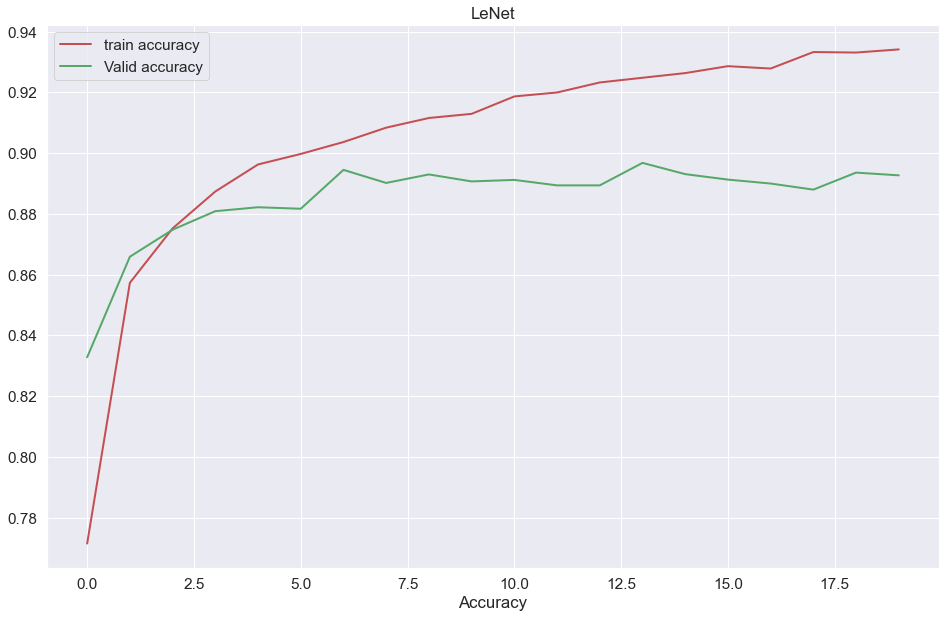

In [309]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("LeNet")
plt.plot(range(max_epochs), accuracy_LeNet["train"], color = 'r', label="train accuracy", linewidth=2)
plt.plot(range(max_epochs), accuracy_LeNet["valid"], color = 'g', label="Valid accuracy", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.xlabel("Accuracy")
plt.show()

## It turned out to increase the score from 86 to 89 on the test

### + dropout and batchnorm

In [320]:
class LeNet5_norm(nn.Module):

    def __init__(self):
        super(LeNet5_norm, self).__init__()
        
        self.convolutional_layer = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(6),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.BatchNorm1d(84),
            nn.Linear(in_features=84, out_features=10),
        )


    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        return x

In [321]:
model = LeNet5_norm_dropout()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

loader_LeNet5_norm = {"train": train_loader, "valid": test_loader}

In [322]:
accuracy_LeNet5_norm = {"train": [], "valid": []}

In [323]:
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train() 
                optimizer.zero_grad()
                output = model(x_batch) 
            else:
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)
            preds = output.argmax(-1) 
            correct = (preds == y_batch).float().sum() 
            all = y_batch.size(0)  
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy_LeNet5_norm[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8120833333333334
Loader: valid. Accuracy: 0.8356
Epoch: 2
Loader: train. Accuracy: 0.8650333333333333
Loader: valid. Accuracy: 0.8673
Epoch: 3
Loader: train. Accuracy: 0.8769166666666667
Loader: valid. Accuracy: 0.8714
Epoch: 4
Loader: train. Accuracy: 0.8843333333333333
Loader: valid. Accuracy: 0.8674
Epoch: 5
Loader: train. Accuracy: 0.8898833333333334
Loader: valid. Accuracy: 0.8794
Epoch: 6
Loader: train. Accuracy: 0.8940833333333333
Loader: valid. Accuracy: 0.8852
Epoch: 7
Loader: train. Accuracy: 0.8970333333333333
Loader: valid. Accuracy: 0.883
Epoch: 8
Loader: train. Accuracy: 0.9017
Loader: valid. Accuracy: 0.878
Epoch: 9
Loader: train. Accuracy: 0.9029166666666667
Loader: valid. Accuracy: 0.8829
Epoch: 10
Loader: train. Accuracy: 0.9073333333333333
Loader: valid. Accuracy: 0.884
Epoch: 11
Loader: train. Accuracy: 0.9081166666666667
Loader: valid. Accuracy: 0.8794
Epoch: 12
Loader: train. Accuracy: 0.9102833333333333
Loader: valid. Accuracy:

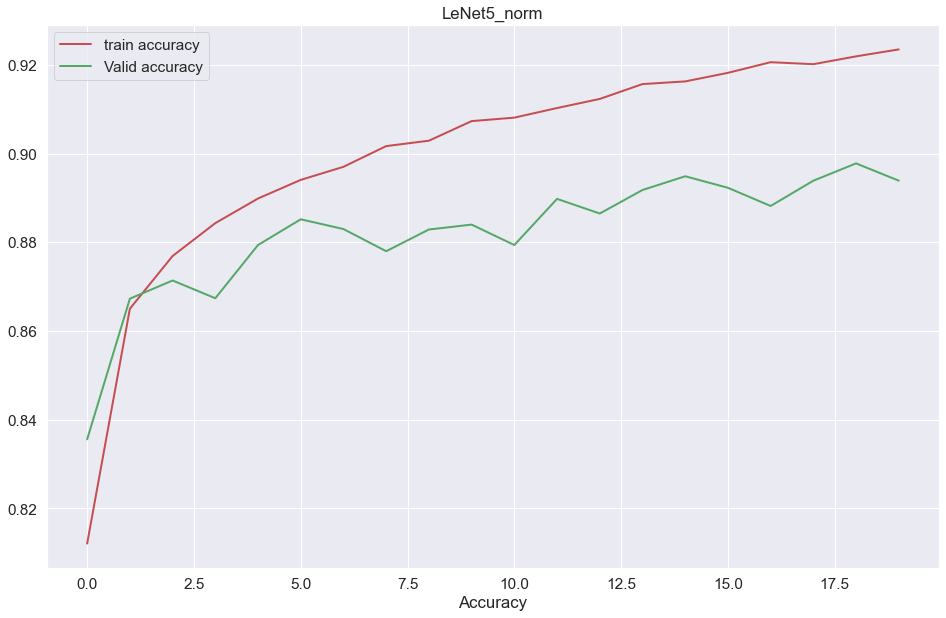

In [324]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("LeNet5_norm")
plt.plot(range(max_epochs), accuracy_LeNet5_norm["train"], color = 'r', label="train accuracy", linewidth=2)
plt.plot(range(max_epochs), accuracy_LeNet5_norm["valid"],color = 'g', label="Valid accuracy", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.xlabel("Accuracy")
plt.show()

#### It did not give an increase compared to a previous convolutional network, apparently this is the maximum for such simple networks